In [1253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from sklearn.utils import shuffle

<p> helper functions and classes </p>

In [1254]:
def see_data_stored(data_from_customDataFunction):
  x = print('\nFirst iteration of data set: ', next(iter(data_from_customDataFunction)), '\n') # Display text and label.
  y =print('Length of data set: ', len(data_from_customDataFunction), '\n')                  # Print how many items are in the data set
  z = print('Entire data set: ', list(DataLoader(data_from_customDataFunction)), '\n')        # Print entire data set
  return x,y,z

In [1255]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

### Prepare data

In [1257]:
# Read in dataset 
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
#Combine treatment and control as pandas dataframe
nswre74_pd_df = pd.concat([nswre74_control,nswre74_treated])
#Drop the outcome variable -> as to not bias results
nswre74_pd_df.drop('re78', axis=1, inplace=True)
#Shuffle data
nswre74_pd_df = shuffle(nswre74_pd_df).reset_index(drop=True)


treat  age  education  black  hispanic  married  nodegree      re74  \
0        1   26         10      1         0        0         1  25929.68   
1        1   17          8      1         0        0         1      0.00   
2        0   33         11      1         0        0         1  10523.83   
3        0   20         10      1         0        0         1      0.00   
4        1   21         12      1         0        0         0      0.00   
..     ...  ...        ...    ...       ...      ...       ...       ...   
440      0   25         10      1         0        1         1      0.00   
441      0   32         11      1         0        0         1      0.00   
442      1   27         11      1         0        0         1      0.00   
443      0   23         11      1         0        0         1      0.00   
444      1   25          5      1         0        0         1      0.00   

         re75  
0    6788.958  
1       0.000  
2    2899.820  
3       0.000  
4       0.000  
..        ...  
440     0.000  
441     0.000  
442     0.000  
443     0.000  
444     0.000  

[445 rows x 9 columns]

In [ ]:
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'


g0 = sns.jointplot(data= nswre74_pd_df,x="age",y="re74", hue= hue, kind=plot_kind)
g1 = sns.jointplot(data= nswre74_pd_df,x="age",y="re75", hue= hue, kind=plot_kind)
g2 = sns.jointplot(data= nswre74_pd_df,x="education",y="re74", hue= hue, kind=plot_kind)
g3 = sns.jointplot(data= nswre74_pd_df,x="education",y="re75", hue= hue, kind=plot_kind)

fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1,4)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[2])
mg3 = SeabornFig2Grid(g3, fig, gs[3])

gs.tight_layout(fig)


In [ ]:
nswre74_pd_df['idx'] = range(1, len(nswre74_pd_df) + 1)
sns.barplot(nswre74_pd_df['treat'],nswre74_pd_df['idx'],data = nswre74_pd_df,capsize= 0.03)
nswre74_pd_df.drop('idx', axis=1, inplace=True)

#### Data pre-processing

In [1269]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

for col in nswre74_pd_df[['age','education','re74','re75']]:
    nswre74_pd_df[col] =  sc.fit_transform(np.array(nswre74_pd_df[col]).reshape(-1,1))

nsw_final_evaluation = nswre74_pd_df[400:445] # Create a subset of data for final evaluation 
nswre74_pd_df = nswre74_pd_df[0:399] # Dataset for K-fold cross validation 


nswre74_array = np.array(nswre74_pd_df)
nswre74_tensor = torch.tensor(nswre74_array)

features = nswre74_array[:,1:]     
target = nswre74_array[::,0]  

FEATURES = torch.tensor(features)
TARGET = torch.tensor(target).unsqueeze(1)
FEATURES

tensor([[ 0.0818, -0.0928,  1.0000,  ...,  1.0000,  4.2739,  1.6561],
        [-1.1735, -1.1975,  1.0000,  ...,  1.0000, -0.3955, -0.4348],
        [ 1.0582,  0.4596,  1.0000,  ...,  1.0000,  1.4996,  0.4583],
        ...,
        [ 1.1977, -0.0928,  1.0000,  ...,  1.0000, -0.3955, -0.4348],
        [-1.0341, -0.0928,  1.0000,  ...,  1.0000, -0.3955, -0.4348],
        [-1.0341,  0.4596,  1.0000,  ...,  1.0000, -0.2410, -0.3687]],
       dtype=torch.float64)

#### Custom class for datasets

In [1270]:
class CustomDataset:
  def __init__(self,features,target):    # initilise class 
    self.features = features              # import features
    self.target = target               # import targets 
  
  def __len__(self):
    #return self.features.shape[0]
    return len(self.features)

  def __getitem__(self,idx):
    
    features = self.features[idx]
    target = self.target[idx]
    #sample = { "features": current_sample,"target": current_target} #Dictionairy storing data
    return (features, target)

 #"features": torch.tensor(current_sample,dtype=torch.float),
 #"target": torch.tensor(current_target,dtype=torch.float),
 

####  Construct NN

<p> set hyper parameters </p>

### Model 

In [1278]:
# Define neural netowrk class 
class NeuralNetwork(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2,num_hidden_3):
        super(NeuralNetwork, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.hidden_layer2 =  nn.Linear(num_hidden_2, num_hidden_3) 
        self.hidden_layer3 =  nn.Linear(num_hidden_3, num_classes) 
       
        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Weight initialisation loop
    
    # Forward propogation method
    def forward(self, x):
        # input 
        x = self.input_layer(x)
        x = self.relu_activation(x)
        # first hidden layer
        x = self.hidden_layer1(x)
        x = self.relu_activation(x)
        # second hidden layer and output
        x = self.hidden_layer2(x)
        x = self.relu_activation(x)
        # third hidden layer and output
        x = self.hidden_layer3(x)
        #x = self.output_activation(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





In [ ]:
# Function to initialise model weights 
def initialize_weights(m):
    classname = m.__class__.__name__
    # For every linear layer in the mdoel   
    if classname.find('Linear') != -1:
      #nn.init.kaiming_uniform_(m.weight.data)
      #nn.init.constant_(m.bias.data, 0)
     n = m.in_features
     y = 1.0/np.sqrt(n)
     m.weight.data.uniform_(-y, y)
     m.bias.data.fill_(0)
    

### K-fold cross validation

<p> Initial settings <p>

In [1272]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.autograd import Variable


In [ ]:
# Function to reset model weights 
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [1279]:
# Set model hyper parameters 
NUM_FEATURES = features.shape[1]
NUM_HIDDEN_1 = 100
NUM_HIDDEN_2 = 50
NUM_HIDDEN_3 = 25                   
NUM_CLASSES = 1

# training configuration options  
NUM_EPOCHS = 100
BATCH_SIZE = 20
Modulo = BATCH_SIZE
LEARNING_RATE = 0.001
k_folds = 5        #number of folds 
fold_results = {}     #store fold results 

splits = KFold(n_splits=k_folds,shuffle=True,random_state=42)
foldperf = {}


### Cross validation 1

In [1282]:
#Set seed
torch.manual_seed(42)
kfold = KFold(n_splits= k_folds, shuffle=True)
dataset = CustomDataset(features = FEATURES,target = TARGET)

# Store test and train loss for each for fold 
fold_training_accuracy, acc_per_epoch,fold_validation_accuracy = {}, {},{}

print("# Start ")

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = SubsetRandomSampler(train_ids)
  test_subsampler = SubsetRandomSampler(test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = DataLoader(dataset,  batch_size=BATCH_SIZE, sampler=train_subsampler)
  testloader = DataLoader(dataset,batch_size=BATCH_SIZE, sampler=test_subsampler)

  # Inititialise the model 
  model = NeuralNetwork(num_features = NUM_FEATURES,
                        num_classes  = NUM_CLASSES, 
                        num_hidden_1 = NUM_HIDDEN_1,
                        num_hidden_2 = NUM_HIDDEN_2,
                        num_hidden_3 = NUM_HIDDEN_3
                        )
  # Reset weights 
  model.apply(reset_weights)
  model.apply(initialize_weights)

  #Initialise optimiser
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
  criterion = nn.BCEWithLogitsLoss()

  # Run training loop over n epochs
  print('* * * Training * * * ') 
  for epoch in range(0, NUM_EPOCHS):
      print('- - - - - - - - -')
      
      # SET LOSS
      current_loss,total_training_samples = 0.0,0
      model.train()

      for idx, (features,target) in enumerate(trainloader,start = 0):       # Iterate over the DataLoader for training data

          # GET DATA  
          features = features.float().to(device)
          target = target.float().to(device)
          # ZERO PARAMETER GRADIENTS  
          optimizer.zero_grad()
          # FORWARD AND BACK PROPOGRATION
          outputs = model(features)
          print(outputs)
          #outputs = Variable((outputs>0.50).float(), requires_grad=True)
          # COMPUTE LOSS
          loss = criterion(outputs , target)
          loss.backward()
          # UPDATE MODEL PARAMETERS
          optimizer.step()

          # * * * * *  LOGGING * * * * * * * 
          #calculate training accuracy
          # At the completion of each epoch , store train losses 
          correct_predicted_training = 0

          current_loss += loss.item()
          total_training_samples += target.size(0)
          predicted_labels = outputs

          #total_train += targets
          predicted_labels = (outputs>0.50).float()
          correct_predicted_training += (predicted_labels.unsqueeze(0) == target.T).sum()
          train_accuracy = correct_predicted_training.float()/ total_training_samples
          fold_training_accuracy[fold]= train_accuracy.item()
    
          # Accuracy = TP + TN / (TP+TN+FP+FN)

          #if batch_idx % batch_idx == batch_idx -1:
          #if idx % 500 == 499:
          #if idx % 100 == 99:    # every batche...
            
          print(f'Fold: {fold}'f' | Epoc: {epoch+1}/{NUM_EPOCHS} 'f'| Batch: {idx}/{len(trainloader)}'f' | Training Loss: {loss:.4f}')
            
          current_loss = 0.0
          acc_per_epoch[epoch] = train_accuracy

          # * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

        #print('Training process has finished. Saving trained model.')

      # SAVE THE MODEL 
      save_path = f'/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/model/model-fold-{fold}.pth'
      torch.save(model.state_dict(), save_path)
      # EVALUATION
  
  print('* * * Evaluation * * * ')     
  validation_correct, validation_total = 0, 0
  model.eval()
  with torch.no_grad():
    for i, (features,target) in enumerate(testloader): # Iterate over the test data and generate predictions
        val_inputs,  val_targets = features, target    

        val_inputs = val_inputs.float().to(device)
        val_targets = val_targets.float().to(device)
        val_outputs = model(val_inputs)

        # * * * * *  calculate validation accuracy * * * * * *
        validation_predicted = (val_outputs>0.50)
        validation_total += val_targets.size(0)

        validation_correct += (validation_predicted.unsqueeze(0) == val_targets.T).sum()
        validation_acc = validation_correct.float()/ validation_total

        fold_validation_accuracy[fold] = validation_acc.item()
        print(f'Fold: {fold}'f' | Validation accuracy: {validation_acc:.2f}%')
        fold_results[fold] = (validation_correct / validation_total)

          # * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')

sum = 0.0
for key, value in fold_results.items():
  print(f'Fold {key} : {value} %')
  sum += value
  print(f'Average: {sum/len(fold_results.items())} %')
  print(' ')


# Start 
* * * Training * * * 
- - - - - - - - -
tensor([[-0.0105],
        [-0.0132],
        [ 0.0037],
        [-0.0064],
        [ 0.0034],
        [ 0.0037],
        [-0.0119],
        [-0.0118],
        [-0.0054],
        [ 0.0024],
        [ 0.0498],
        [-0.0137],
        [-0.0130],
        [-0.0016],
        [ 0.0114],
        [ 0.0209],
        [ 0.0004],
        [-0.0063],
        [ 0.0004],
        [-0.0064]], grad_fn=<AddmmBackward0>)
Fold: 0 | Epoc: 1/100 | Batch: 0/16 | Training Loss: 0.6917
tensor([[-0.0015],
        [-0.0036],
        [ 0.0016],
        [-0.0131],
        [ 0.0010],
        [ 0.0062],
        [ 0.0118],
        [-0.0030],
        [-0.0150],
        [-0.0154],
        [-0.0202],
        [ 0.0144],
        [ 0.0050],
        [-0.0075],
        [ 0.0039],
        [-0.0022],
        [-0.0050],
        [-0.0085],
        [ 0.0221],
        [-0.0111]], grad_fn=<AddmmBackward0>)
Fold: 0 | Epoc: 1/100 | Batch: 1/16 | Training Loss: 0.6948
tensor([[ 0.0125]

In [1275]:
acc_per_epoch

{0: tensor(1.0625),
 1: tensor(0.7500),
 2: tensor(0.8750),
 3: tensor(0.5625),
 4: tensor(0.6812),
 5: tensor(0.7375),
 6: tensor(0.6750),
 7: tensor(0.6562),
 8: tensor(0.6750),
 9: tensor(0.6562),
 10: tensor(0.6875),
 11: tensor(0.7375),
 12: tensor(0.5375),
 13: tensor(0.8125),
 14: tensor(0.6875),
 15: tensor(0.8125),
 16: tensor(0.6562),
 17: tensor(0.5500),
 18: tensor(0.7375),
 19: tensor(0.6625),
 20: tensor(0.7375),
 21: tensor(0.6750),
 22: tensor(0.6250),
 23: tensor(0.6812),
 24: tensor(0.5750),
 25: tensor(0.6250),
 26: tensor(0.6250),
 27: tensor(0.5938),
 28: tensor(0.7000),
 29: tensor(0.6250),
 30: tensor(0.8000),
 31: tensor(0.5312),
 32: tensor(0.6250),
 33: tensor(0.6000),
 34: tensor(0.7500),
 35: tensor(0.8500),
 36: tensor(0.6500),
 37: tensor(0.6625),
 38: tensor(0.7563),
 39: tensor(0.7000),
 40: tensor(0.8125),
 41: tensor(0.9062),
 42: tensor(0.5875),
 43: tensor(0.7750),
 44: tensor(0.6250),
 45: tensor(0.5750),
 46: tensor(0.6562),
 47: tensor(0.6500),
 4

<function matplotlib.pyplot.show(close=None, block=None)>

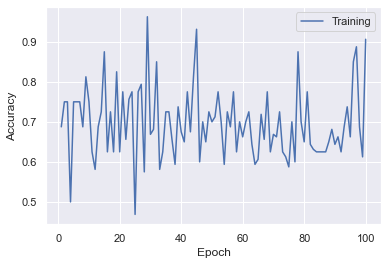

In [1281]:
# Plot accuracy
num_epochs = len(acc_per_epoch)
num_epochs2 = len(fold_validation_accuracy)

plt.plot(np.arange(1, num_epochs+1),acc_per_epoch.values(), label='Training')
#plt.plot(np.arange(1, num_epochs2+1),fold_validation_accuracy.values(), label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plt.tight_layout()
plt.savefig('plot_acc_training_validation.pdf')
plt.show

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
y_pred = []
y_true = []

dataset = CustomDataset(features = FEATURES,target = TARGET)
trainloader = DataLoader(dataset,  batch_size=BATCH_SIZE)

# iterate over test data
for idx,(features,target) in enumerate(trainloader,start = 0):
        
        target2 = target
        features = features.float().to(device)
        target = target.float().to(device)
       
        output = model(features) # Feed Network

        outputs =(outputs>0.50)
        outputs = (torch.max(torch.exp(output), 1)[1]).numpy()
        y_pred.extend(outputs) # Save Prediction
        
        target = target.numpy()
        y_true.extend(target) # Save Truth

# constant for classes
classes = ('treatment', 'control')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
                                              

In [ ]:
output = model(features)
output

### Cross validation 2

<p> Plot loss and accuracy </p>

### Validating model 

In [ ]:
# Load hold out data for a quick yesy
nsw_final_evaluation = np.array(nsw_final_evaluation)

features_validation = nsw_final_evaluation[:,1:]     
target_validation = nsw_final_evaluation[::,0]  

features_validation = torch.tensor(features_validation)
target_validation = torch.tensor(target_validation).unsqueeze(1)

validation_loader = CustomDataset(features = features_validation,targets = target_validation)

validation_loader = DataLoader(dataset=validation_loader, batch_size=BATCH_SIZE,shuffle=True)


In [ ]:
X = validation_loader['features']
Y = validation_loader['target']

X = X.float()
Y = Y.float()


out = model(X)
out